In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases.
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    # Check if 'composition' exists and is not None
    if not entry.get('composition'):
        # print(f"Skipping entry with title '{entry.get('title', 'Unknown Title')}' due to missing 'composition'")
        continue
    # Set each element to 1 if it is present and it's a valid element, otherwise skip it
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and binary label columns (y)
X = df.copy()  # Features
y = df.copy()  # Multi-label targets, each element is its own label

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = X_train.columns[X_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))



============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-150 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-1 | Actual: Co, Cr, Fe, Mn, Cu, Si | Predicted: Co, Cr, Fe, Mn, Cu, Si
paper-110 | Actual: Al, Si, Mg | Predicted: Al, Si, Mg
paper-131 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-144 | Actual: Ti, Zr, Hf, Ta, Mo, N | Predicted: Ti, Zr, Hf, Ta, Mo, N
paper-210 | Actual: Nb, Ta, Mo, C, W | Predicted: Nb, Ta, Mo, C, W
paper-218 | Actual: Co, Cr, Fe, Ni, Al, Cu | Predicted: Co, Cr, Fe, Ni, Al, Cu
paper-229 | Actual: Ti, Zr, V, Nb, Al | Predicted: Ti, Zr, V, Nb, Al

Accuracy for Fold 1: 100.00%

Classification Report for Fold:
              precision    recall  f1-score   support

          Co       1.00      1.00      1.00         6
          Cr   

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []
periodic_elements = { "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"}

for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)

X = df.copy()
y = df.copy()

base_classifier = DecisionTreeClassifier(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_test = [titles[i] for i in test_index]

    train_columns = X_train.columns[X_train.any() == 1]
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)
    y_pred = classifier_chain.predict(X_test_filtered)

    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")
    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))

    # Visualize each decision tree in the classifier chain
    for idx, classifier in enumerate(classifier_chain.estimators_):
        plt.figure(figsize=(20, 10))
        plot_tree(classifier, filled=True, feature_names=X_train_filtered.columns, class_names=['Absent', 'Present'])
        plt.title(f"Decision Tree for Classifier {idx + 1}")
        plt.show()



Output hidden; open in https://colab.research.google.com to view.

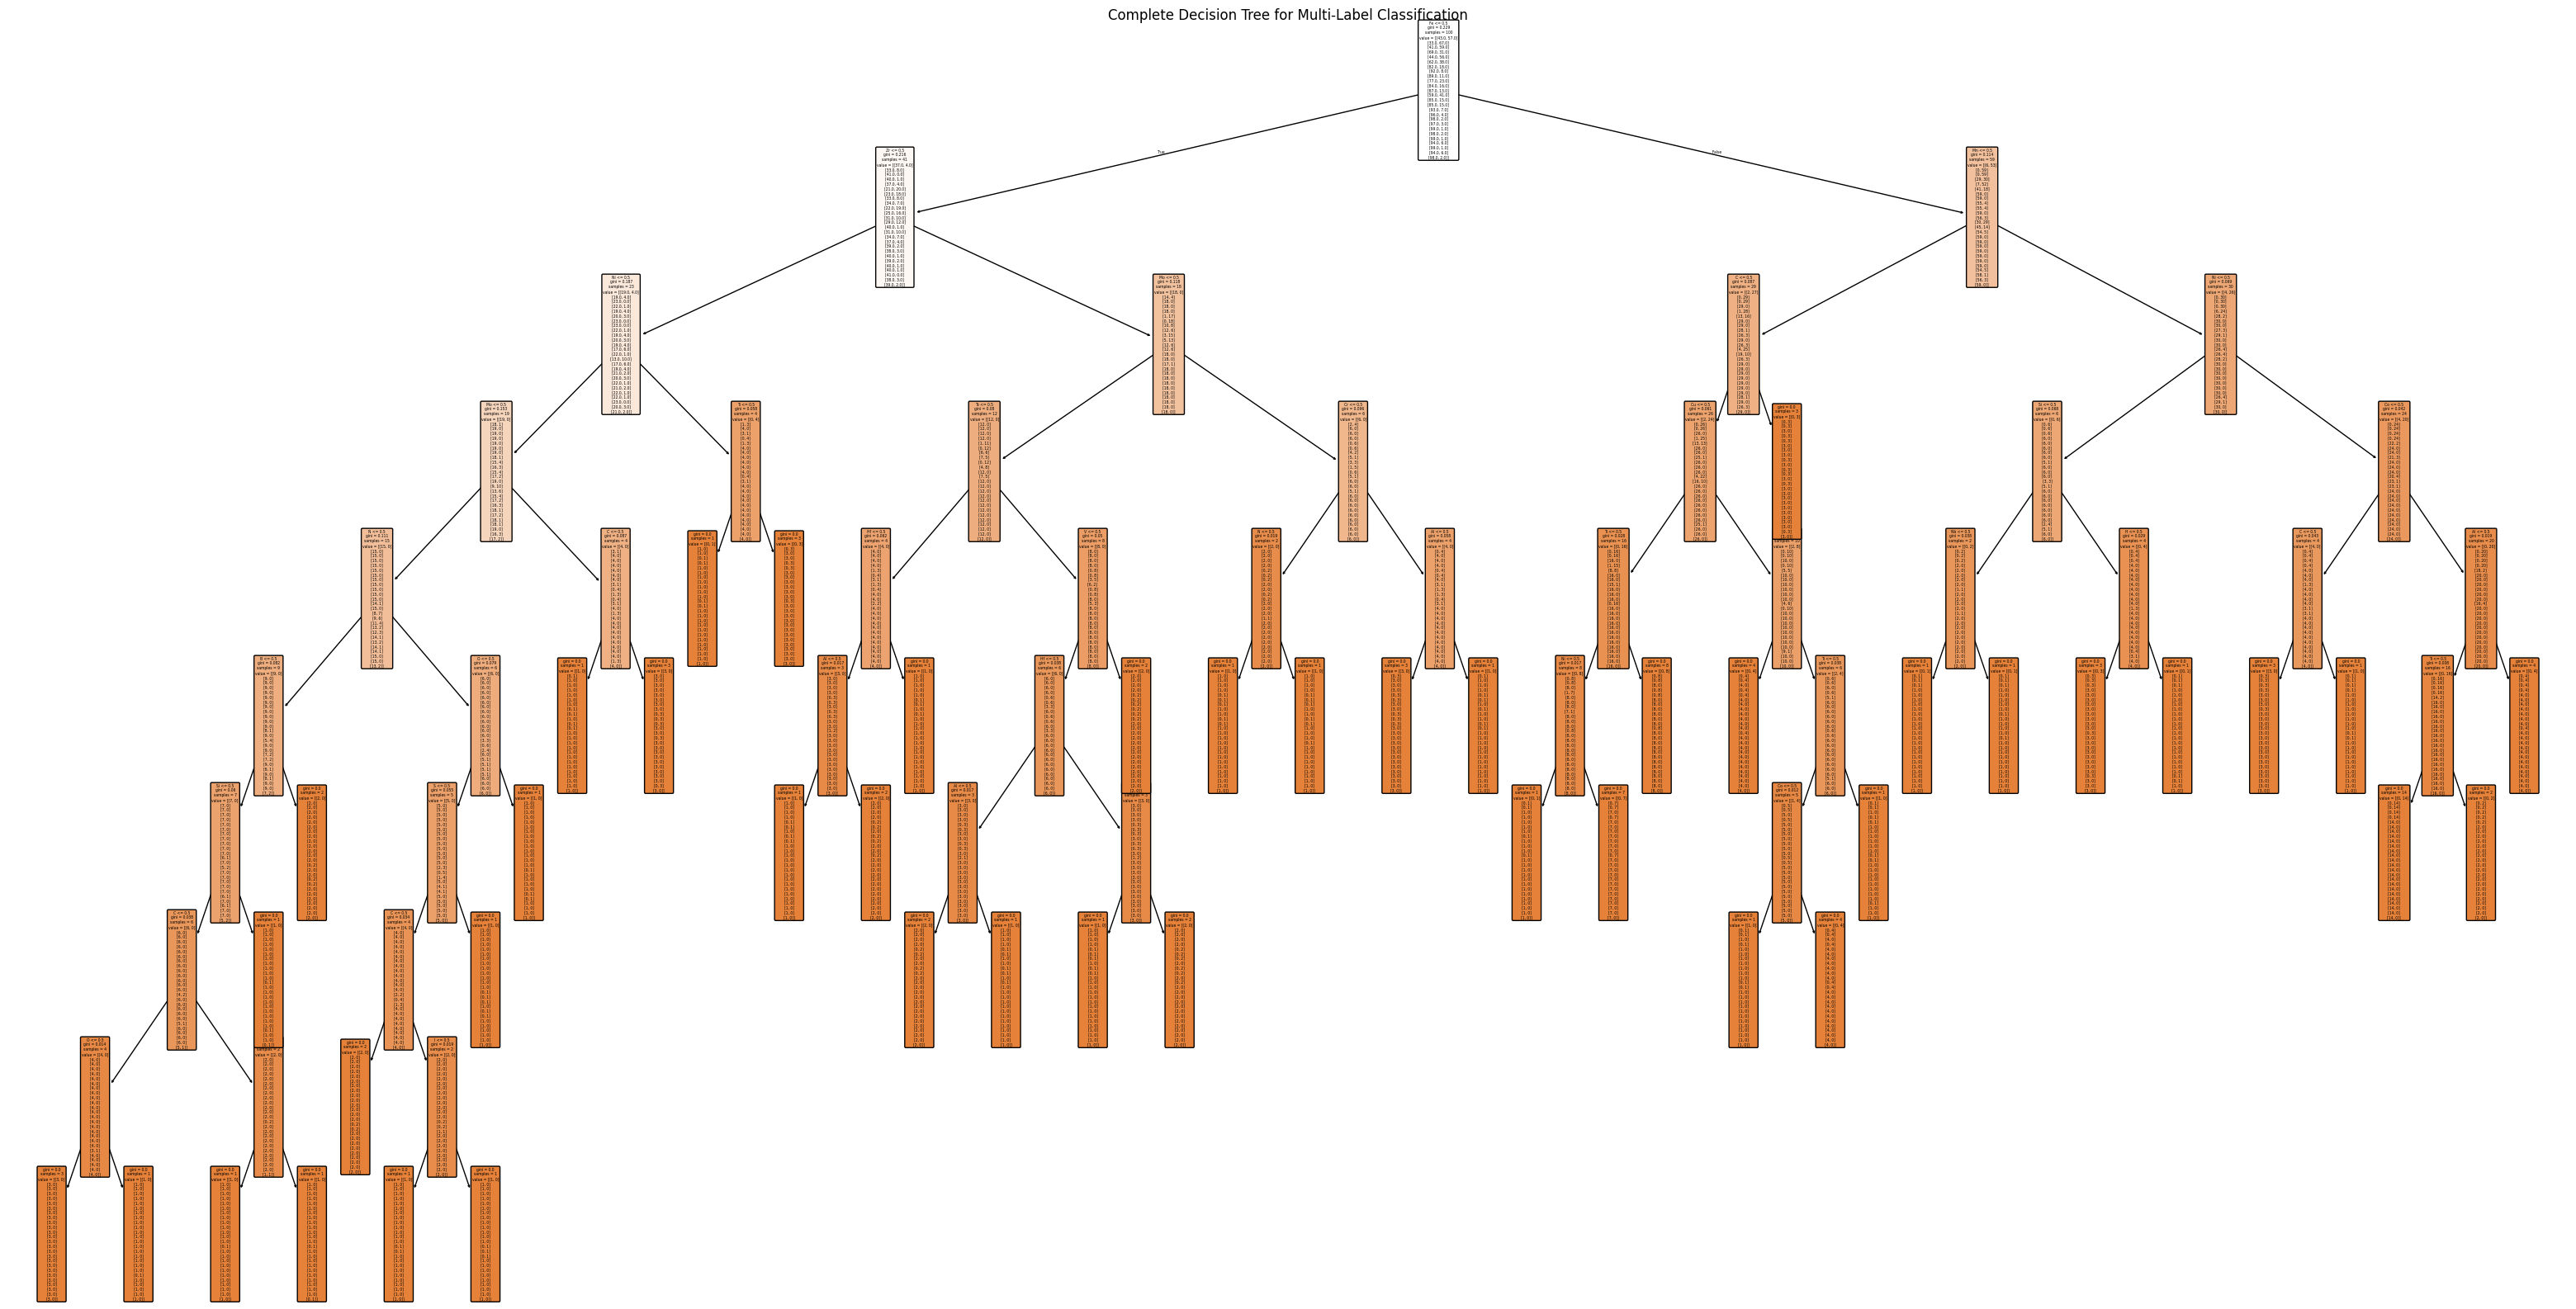

In [ ]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and labels (y)
X = df.copy()
y = df.copy()

# Initialize and train a single Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X, y)

# Visualize the complete decision tree
plt.figure(figsize=(40, 20))
plot_tree(classifier, feature_names=X.columns, class_names=['Absent', 'Present'], filled=True, rounded=True)
plt.title("Complete Decision Tree for Multi-Label Classification")
plt.show()

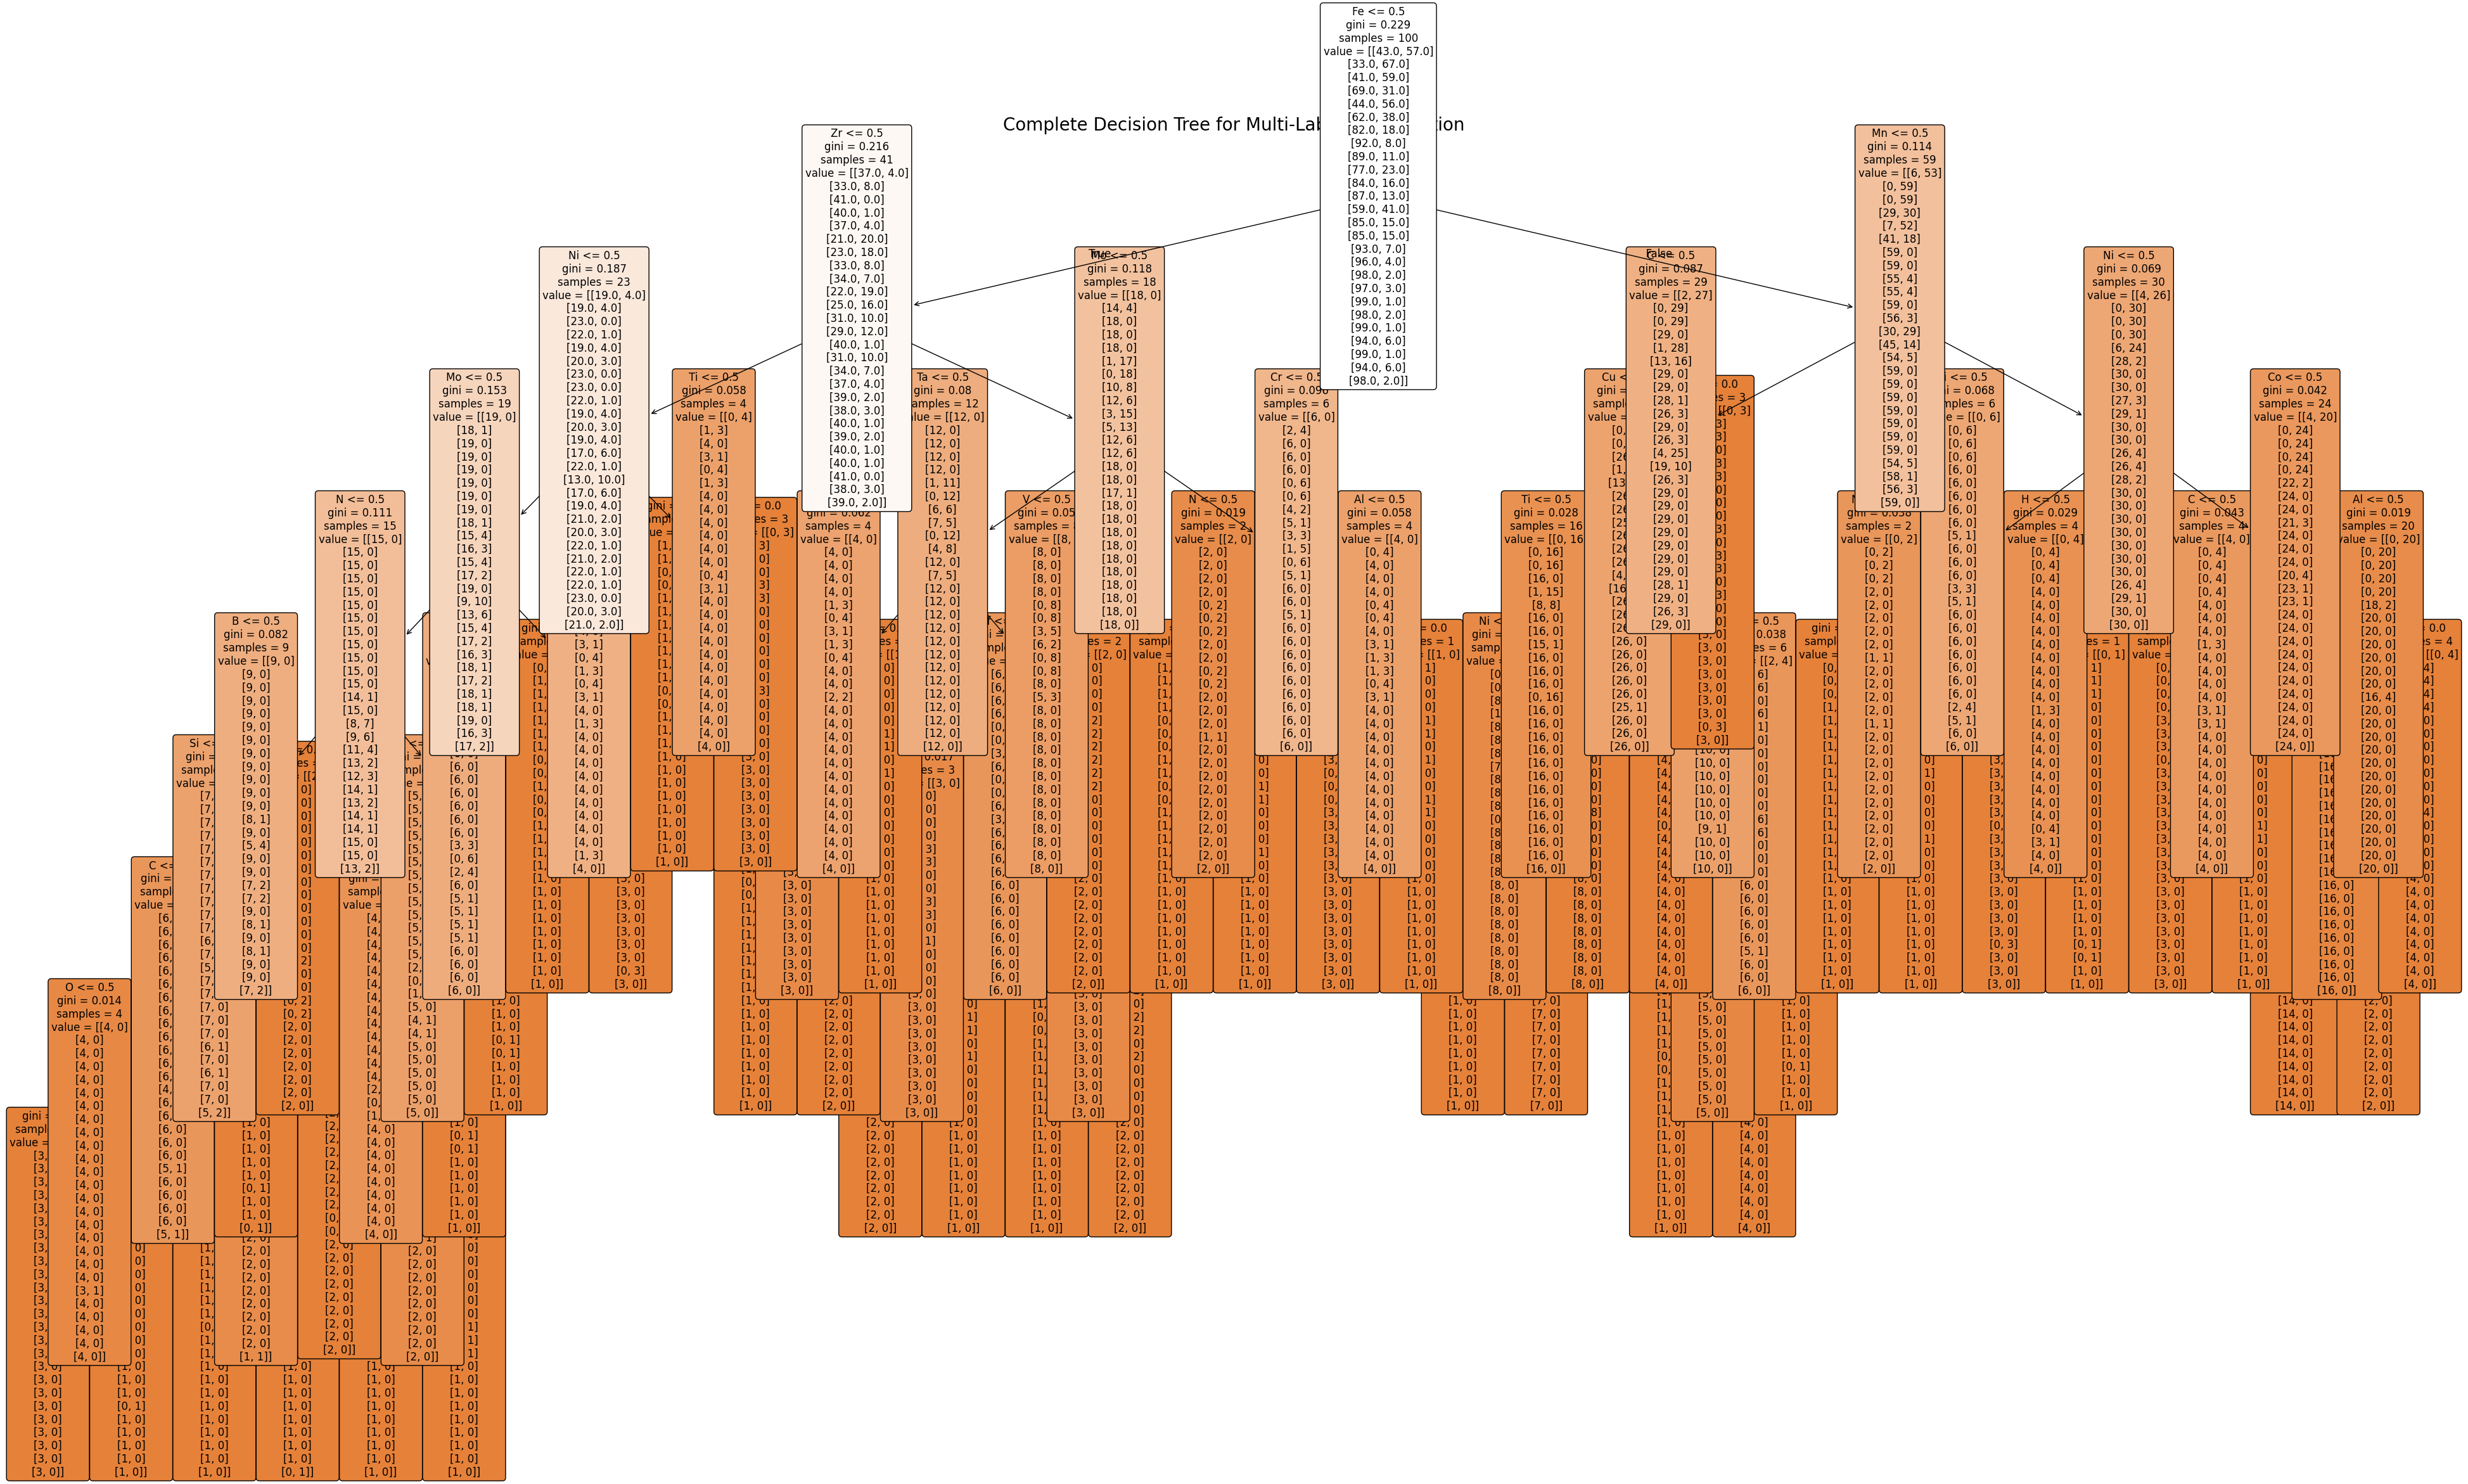

In [ ]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and labels (y)
X = df.copy()
y = df.copy()

# Initialize and train a single Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X, y)

# Visualize the complete decision tree with larger text size
plt.figure(figsize=(50, 25))
plot_tree(classifier, feature_names=X.columns, class_names=['Absent', 'Present'], filled=True, rounded=True, fontsize=12)
plt.title("Complete Decision Tree for Multi-Label Classification", fontsize=20)
plt.show()


In the decision tree visualization, the value attribute represents the distribution of labels at each node for your multi-label classification problem.

Since you're predicting multiple chemical elements (multi-label), each value is shown as an array of arrays:

Outer Array: Represents each label (chemical element) being predicted.
Inner Arrays: Contain counts for the two classes—[Absent, Present].
For example, if you see something like:

lua
Copy
Edit
value = [[[5, 3], [6, 2], [4, 4], ...]]
It means:

First inner array [5, 3]: For the first element, 5 samples are labeled as Absent, and 3 are labeled as Present at this node.
Second inner array [6, 2]: For the second element, 6 samples are Absent, and 2 are Present.
And so on for each subsequent element.
This structure helps the classifier decide which elements are likely to be present in a composition based on the splits made at each node.

In [ ]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and labels (y)
X = df.copy()
y = df.copy()

# Initialize and train a single Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X, y)

# Visualize the complete decision tree without the 'value' attribute
plt.figure(figsize=(50, 25))
plot_tree(
    classifier,
    feature_names=X.columns,
    class_names=['Absent', 'Present'],
    filled=True,
    rounded=True,
    fontsize=12,
    impurity=True,
    proportion=True,
    label='root'  # Changed from 'root' to 'none' to remove value labels
)
plt.title("Complete Decision Tree for Multi-Label Classification (Values Removed)", fontsize=20)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and labels (y)
X = df.copy()
y = df.copy()

# Initialize and train a single Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X, y)

# Visualize the decision tree with clean node display
plt.figure(figsize=(50, 25))
plot_tree(
    classifier,
    feature_names=X.columns,
    class_names=['Absent', 'Present'],
    filled=True,
    rounded=True,
    fontsize=12,
    proportion=False,    # Removes the sample proportions
    impurity=False,      # Removes the impurity scores
    node_ids=False,      # Removes node IDs
    precision=3          # Reduces decimal places in numbers
)
plt.title("Decision Tree for Multi-Label Classification", fontsize=20)
plt.tight_layout()  # Adjusts the layout to prevent text overlap
plt.show()

Output hidden; open in https://colab.research.google.com to view.

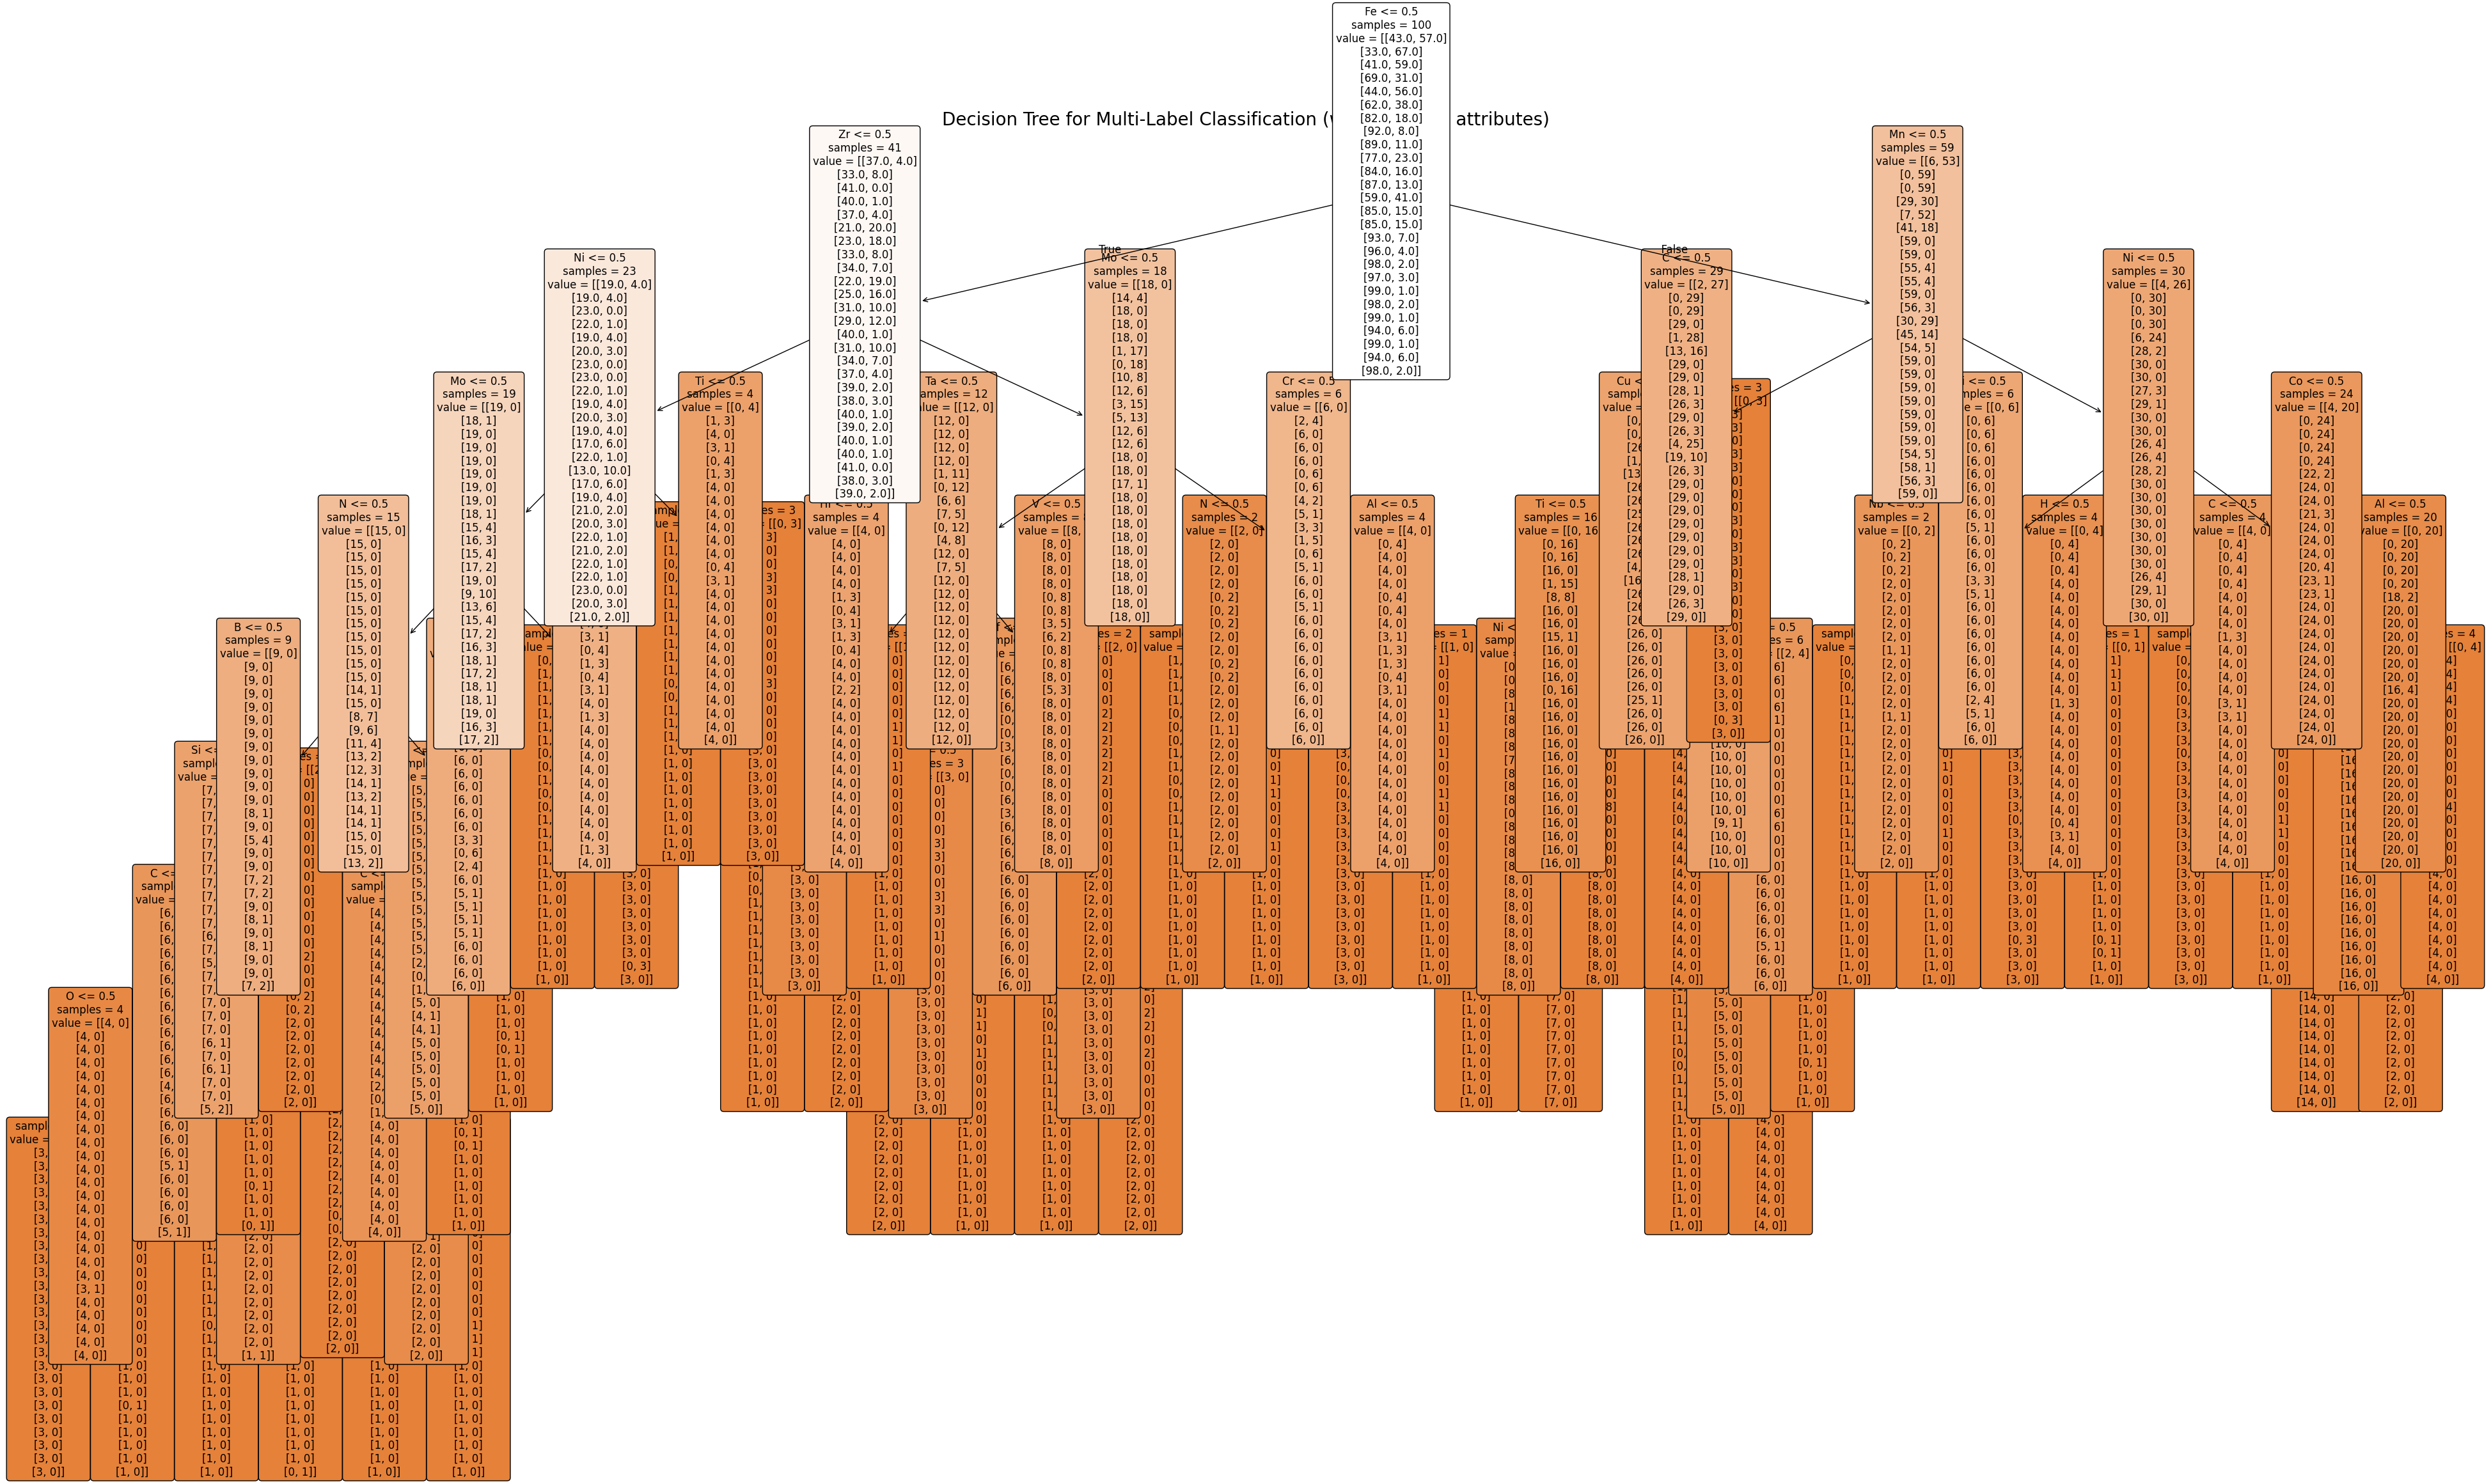

In [ ]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and labels (y)
X = df.copy()
y = df.copy()

# Initialize and train a single Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X, y)

# Visualize the decision tree without value attributes
plt.figure(figsize=(50, 25))
plot_tree(
    classifier,
    feature_names=X.columns,
    class_names=['Absent', 'Present'],
    filled=True,
    rounded=True,
    fontsize=12,
    proportion=False,  # This removes the value array
    impurity=False,    # This removes the impurity scores
    label = 'all'
)
plt.title("Decision Tree for Multi-Label Classification (without value attributes)", fontsize=20)
plt.show()

#NEW

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases.
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and additional features
compositions = []
additional_features = []  # To store b0, d1, d2, ei
titles = []

for entry in data:
    # Skip entries with missing composition
    if not entry.get('composition'):
        continue

    # Extract composition (binary features)
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}

    # Skip materials with no valid elements
    if not composition:
        continue

    titles.append(entry['title'])
    compositions.append(composition)

    # Extract additional features (b0, d1, d2, ei)
    additional_features.append({
        'b0': entry.get('b0', 0),  # Use 0 as default if missing
        'd1': entry.get('d1', 0),
        'd2': entry.get('d2', 0),
        'ei': entry.get('ei', 0)
    })

# Convert compositions and additional features to DataFrames
df_compositions = pd.DataFrame(compositions)
df_additional = pd.DataFrame(additional_features)

# Combine composition and additional features into a single feature matrix
X = pd.concat([df_compositions, df_additional], axis=1)
X.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define targets (y) as the composition DataFrame
y = df_compositions.copy()
y.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = y_train.columns[y_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))


============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-150 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-129 | Actual: Ti, Zr, Nb, Ta | Predicted: Ti, Zr, Nb, Ta
paper-162 | Actual: N, I | Predicted: N, I
paper-129 | Actual: Ti, Zr, Nb, Ta | Predicted: Ti, Zr, Nb, Ta
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-205 | Actual: Co, Cr, Ni, Ti, Al | Predicted: Co, Cr, Ni, Ti, Al
paper-209 | Actual: Cr, Fe, Mn, Ni, V | Predicted: Cr, Fe, Mn, Ni, V
paper-230 | Actual: Co, Cr, Fe, Ni, Al, Cu | Predicted: Co, Cr, Fe, Ni, Al, Cu
paper-221 | Actual: Co, Cr, Fe, V, Al | Predicted: Co, Cr, Fe, V, Al
paper-238 | Actual: Co, Mn, Ni, Al, Cu | Predicted: Co, Mn, Ni, Al, Cu

Accuracy for Fold 1: 100.00%

Classification Report for Fold:
              precision    recall  f1-score   support

          Co       1.00      1.00      1.00         6
          Cr       1.00      1.00      1.00         6

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting features (b0, d1, d2, ei) and composition data
features = []
compositions = []
titles = []
valid_entries = 0

for entry in data:
    # Check if 'composition' exists and is not None and required features exist
    if (not entry.get('composition') or
        'b0' not in entry or
        'd1' not in entry or
        'd2' not in entry or
        'ei' not in entry):
        continue

    # Extract physical properties as features
    feature = {
        'b0': entry.get('b0', 0),
        'd1': entry.get('d1', 0),
        'd2': entry.get('d2', 0),
        'ei': entry.get('ei', 0)
    }

    # Extract composition as target (binary representation)
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}

    features.append(feature)
    compositions.append(composition)
    titles.append(entry['title'])
    valid_entries += 1

print(f"Processing {valid_entries} valid entries with complete data")

# Convert to DataFrames
X = pd.DataFrame(features)  # Features are now physical properties
y = pd.DataFrame(compositions)  # Targets are element compositions
y.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Print dataset shape information
print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")
print(f"Number of unique elements in dataset: {len(y.columns)}")

# Initialize the base classifier - using a more complex tree for this task
base_classifier = DecisionTreeClassifier(random_state=42, max_depth=10)

# Set up K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Track overall performance metrics
all_accuracies = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = y_train.columns[y_train.any() == 1]

    if len(train_columns) == 0:
        print("No elements found in training data for this fold. Skipping fold.")
        continue

    print(f"Training with {len(train_columns)} elements that appear in training data")

    # Filter the target data to only include elements present in the training data
    y_train_filtered = y_train[train_columns]
    y_test_filtered = y_test[train_columns]

    # Feature scaling - normalize the physical properties
    for col in X_train.columns:
        mean = X_train[col].mean()
        std = X_train[col].std()
        if std > 0:  # Avoid division by zero
            X_train[col] = (X_train[col] - mean) / std
            X_test[col] = (X_test[col] - mean) / std

    # Initialize and train the classifier chain model
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train, y_train_filtered)

    # Predict compositions based on physical properties
    y_pred = classifier_chain.predict(X_test)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("\nMaterial Predictions:")
    print("Title | Physical Properties | Actual Elements | Predicted Elements")
    for i, (title, actual, predicted) in enumerate(zip(titles_test, y_test_filtered.values, y_pred)):
        # Get the physical properties for this test sample
        props = " ".join([f"{col}={X_test.iloc[i][col]:.2f}" for col in X_test.columns])

        # Get actual and predicted elements
        actual_labels = ', '.join([col for col, val in zip(train_columns, actual) if val == 1])
        if not actual_labels:
            actual_labels = "None"

        predicted_labels = ', '.join([col for col, val in zip(train_columns, predicted) if val == 1])
        if not predicted_labels:
            predicted_labels = "None"

        print(f"{title} | {props} | {actual_labels} | {predicted_labels}")

    # Calculate and print accuracy for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    all_accuracies.append(accuracy)
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    # Print feature importance
    print("\nFeature Importance Analysis:")
    importances = {}
    for i, chain_classifier in enumerate(classifier_chain.estimators_):
        if hasattr(chain_classifier, 'feature_importances_'):
            element = train_columns[i]
            feature_importances = chain_classifier.feature_importances_[:len(X.columns)]
            importance_dict = {feature: importance for feature, importance
                              in zip(X.columns, feature_importances)}
            most_important = max(importance_dict.items(), key=lambda x: x[1])
            importances[element] = most_important
            print(f"For predicting {element}, most important feature is {most_important[0]} (importance: {most_important[1]:.4f})")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))

# Print overall performance summary
if all_accuracies:
    print(f"\n{'='*30} Overall Performance {'='*30}")
    print(f"Average Accuracy across all folds: {np.mean(all_accuracies):.2f}%")
    print(f"Standard Deviation of Accuracy: {np.std(all_accuracies):.2f}%")
    print(f"Min Accuracy: {min(all_accuracies):.2f}%, Max Accuracy: {max(all_accuracies):.2f}%")

Processing 100 valid entries with complete data
Feature matrix shape: (100, 4)
Target matrix shape: (100, 26)
Number of unique elements in dataset: 26

============================== Fold 1 Results ==============================
Training with 25 elements that appear in training data

Material Predictions:
Title | Physical Properties | Actual Elements | Predicted Elements
paper-150 | b0=0.29 d1=-0.29 d2=-0.69 ei=0.90 | Co, Cr, Fe, Mn, Ni | Co, Cr, Fe, Mn, Ni
paper-139 | b0=0.29 d1=-0.11 d2=1.60 ei=-0.81 | Ti, Zr, Hf, V, Nb, Ta | Ti, Zr, Hf, V, Nb, Ta
paper-133 | b0=0.29 d1=-0.29 d2=-0.23 ei=0.04 | Co, Cr, Fe, Mn, Ni | Co, Cr, Fe, Ni, Ti, Al
paper-127 | b0=0.29 d1=-0.26 d2=-0.69 ei=-0.81 | Co, Cr, Fe, Ni, Ti, Cu | Co, Cr, Fe, Ni, Ti, Cu
paper-173 | b0=0.29 d1=-0.30 d2=-0.69 ei=1.75 | N, O | None
paper-1 | b0=0.29 d1=-0.29 d2=-0.69 ei=-0.81 | Co, Cr, Fe, Mn, Cu, Si | Ti, Zr, Nb, C, N, I
paper-26 | b0=-15639879.43 d1=-0.28 d2=-0.69 ei=-0.81 | Co, Cr, Fe, Mn, Ni | Co, Cr, Ni, Ti, Al
paper-7

<ipython-input-8-093aa2a6c900>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = (X_train[col] - mean) / std
<ipython-input-8-093aa2a6c900>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = (X_test[col] - mean) / std
<ipython-input-8-093aa2a6c900>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta


Material Predictions:
Title | Physical Properties | Actual Elements | Predicted Elements
paper-138 | b0=0.11 d1=-0.21 d2=0.83 ei=-0.88 | Cr, Ti, Zr, Nb, Ta, Mo | Cr, Ti, Zr, Nb, Ta, Mo
paper-131 | b0=0.11 d1=-0.17 d2=-0.63 ei=-0.03 | Co, Cr, Fe, Mn, Ni | Ti, Zr, Hf, Ta, Mo
paper-128 | b0=0.11 d1=-0.25 d2=1.80 ei=-0.88 | Co, Cr, Fe, Ni, Ti, Cu | Co, Cr, Fe, Ni, Al, Cu
paper-171 | b0=0.11 d1=-0.26 d2=-0.63 ei=-0.88 | N, I | C, B, S
paper-174 | b0=0.11 d1=-0.26 d2=-0.63 ei=0.82 | C, B, S | Co, Cr, Fe, Mn, Ni
paper-6 | b0=0.11 d1=-0.27 d2=-0.63 ei=-0.88 | Co, Cr, Fe, Mn, Ni | Cr, Fe, Mn, Ni, V
paper-23 | b0=0.11 d1=-0.26 d2=-0.63 ei=-0.03 | Co, Cr, Fe, Mn, Cu, Si | Co, Cr, Fe, Mn, Ni, Al
paper-31 | b0=0.11 d1=-0.26 d2=-0.63 ei=-0.03 | Co, Cr, Fe, Mn, Si | Co, Cr, Fe, Mn, Ni
paper-109 | b0=0.11 d1=-0.16 d2=0.83 ei=-0.88 | C, Mg | Ti, Zr, Nb, Ta
paper-128 | b0=0.11 d1=-0.25 d2=1.80 ei=-0.88 | Co, Cr, Fe, Ni, Ti, Cu | Co, Cr, Fe, Ni, Al, Cu
paper-137 | b0=0.11 d1=7.46 d2=1.80 ei=-0.88 | Co, 

<ipython-input-8-093aa2a6c900>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = (X_train[col] - mean) / std
<ipython-input-8-093aa2a6c900>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = (X_test[col] - mean) / std
<ipython-input-8-093aa2a6c900>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta


Material Predictions:
Title | Physical Properties | Actual Elements | Predicted Elements
paper-8 | b0=0.11 d1=-0.27 d2=-0.73 ei=0.97 | Co, Cr, Fe, Mn, Ni | Co, Cr, Fe, Mn, Ni
paper-127 | b0=0.11 d1=-0.23 d2=-0.73 ei=-0.82 | Co, Cr, Fe, Ni, Ti, Cu | Co, Cr, Fe, Ni, Ti, Cu
paper-129 | b0=0.11 d1=-0.19 d2=0.17 ei=-0.82 | Ti, Zr, Nb, Ta | Ti, Zr, Nb, Ta
paper-134 | b0=0.11 d1=-0.26 d2=-0.73 ei=0.08 | Co, Cr, Fe, Ni, Ti, Al | Co, Cr, Fe, Mn, Ni
paper-138 | b0=0.11 d1=-0.24 d2=0.63 ei=-0.82 | Cr, Ti, Zr, Nb, Ta, Mo | Co, Cr, Ni, Ti, Zr, Mo, Al, N
paper-140 | b0=0.11 d1=-0.22 d2=-0.73 ei=-0.82 | Cr, Ti, Zr, Nb, Ta, Mo | None
paper-145 | b0=0.11 d1=-0.24 d2=-0.73 ei=0.08 | Ti, Zr, Hf, Nb, Ta, Al | Co, Cr, Fe, Mn, Ni
paper-150 | b0=0.11 d1=-0.27 d2=-0.73 ei=0.97 | Co, Cr, Fe, Mn, Ni | Co, Cr, Fe, Mn, Ni
paper-151 | b0=0.11 d1=-0.24 d2=-0.73 ei=0.08 | Co, Cr, Fe, Ni, Ti, Al | Co, Cr, Fe, Mn, Ni
paper-152 | b0=0.11 d1=-0.27 d2=-0.73 ei=0.08 | Co, Cr, Fe, Ni, Ti, Al | None
paper-153 | b0=0.11 d1=

<ipython-input-8-093aa2a6c900>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = (X_train[col] - mean) / std
<ipython-input-8-093aa2a6c900>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = (X_test[col] - mean) / std


In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load JSON data
with open('/content/admin.materials_100.json', 'r') as file:
    data = json.load(file)

# Extract unique elements for composition features
element_set = set()
for entry in data:
    element_set.update(entry['composition'].keys())
element_list = sorted(list(element_set))  # Ensure consistent order

# Extract features (b0, d1, d2, ei) and target labels (composition elements)
def extract_features_labels(entry):
    # Extract numerical features
    features = {
        'b0': entry.get('b0', 0),
        'd1': entry.get('d1', 0),
        'd2': entry.get('d2', 0),
        'ei': entry.get('ei', 0)
    }
    # Extract composition labels
    labels = {element: 1 if element in entry['composition'] else 0 for element in element_list}
    return features, labels

# Process dataset
feature_list, label_list = zip(*[extract_features_labels(entry) for entry in data])
X = pd.DataFrame(feature_list)  # Numerical features
Y = pd.DataFrame(label_list)    # Binary composition labels

# K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
all_reports = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Train Classifier Chain with Decision Trees
    base_model = DecisionTreeClassifier(random_state=42)
    chain_model = ClassifierChain(base_model, order='random', random_state=42)
    chain_model.fit(X_train, Y_train)

    # Predict
    Y_pred = chain_model.predict(X_test)

    # Evaluate
    acc = accuracy_score(Y_test, Y_pred)
    accuracies.append(acc)
    report = classification_report(Y_test, Y_pred, zero_division=0)
    all_reports.append(report)

    print(f'Fold Accuracy: {acc:.4f}')
    print(report)

# Overall Accuracy
print(f'Average Accuracy: {np.mean(accuracies):.4f}')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting features and composition data
features = []
compositions = []
titles = []
valid_entries = 0

for entry in data:
    # Check if composition exists and all required features are present
    if (not entry.get('composition') or
        'b0' not in entry or
        'd1' not in entry or
        'd2' not in entry or
        'ei' not in entry):
        continue

    # Extract all available physical properties as features
    feature = {
        'b0': entry.get('b0', 0),
        'd1': entry.get('d1', 0),
        'd2': entry.get('d2', 0),
        'ei': entry.get('ei', 0),
        'ee': entry.get('ee', 0),      # Additional features if available
        'n': entry.get('n', 0),
        'k': entry.get('k', 0)
    }

    # Extract composition as target (binary representation)
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}

    features.append(feature)
    compositions.append(composition)
    titles.append(entry['title'])
    valid_entries += 1

print(f"Processing {valid_entries} valid entries with complete data")

# Convert to DataFrames
X_raw = pd.DataFrame(features)  # Features are now physical properties
y = pd.DataFrame(compositions)  # Targets are element compositions
y.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Print dataset shape information
print(f"Feature matrix shape: {X_raw.shape}")
print(f"Target matrix shape: {y.shape}")
print(f"Number of unique elements in dataset: {len(y.columns)}")

# Feature engineering - create interaction terms
X = X_raw.copy()
X['b0_d1'] = X_raw['b0'] * X_raw['d1']
X['b0_d2'] = X_raw['b0'] * X_raw['d2']
X['d1_d2'] = X_raw['d1'] * X_raw['d2']
X['b0_ei'] = X_raw['b0'] * X_raw['ei']
X['d1_ei'] = X_raw['d1'] * X_raw['ei']

# Initialize the classifier - using RandomForest for better performance
base_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)

# Set up K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Track overall performance metrics
all_accuracies = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Create proper copies of the data for training and testing
    X_train = X.iloc[train_index].copy()
    X_test = X.iloc[test_index].copy()
    y_train = y.iloc[train_index].copy()
    y_test = y.iloc[test_index].copy()
    titles_test = [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = y_train.columns[y_train.sum() > 0]

    if len(train_columns) == 0:
        print("No elements found in training data for this fold. Skipping fold.")
        continue

    print(f"Training with {len(train_columns)} elements that appear in training data")

    # Filter the target data to only include elements present in the training data
    y_train_filtered = y_train[train_columns]
    y_test_filtered = y_test[train_columns]

    # Feature scaling using StandardScaler (properly handles the SettingWithCopyWarning)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame to maintain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Initialize and train the classifier chain model
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_scaled, y_train_filtered)

    # Predict compositions based on physical properties
    y_pred = classifier_chain.predict(X_test_scaled)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("\nMaterial Predictions:")
    print("Title | Physical Properties | Actual Elements | Predicted Elements")
    for i, (title, actual, predicted) in enumerate(zip(titles_test, y_test_filtered.values, y_pred)):
        # Get the physical properties for this test sample - showing only original features, not engineered ones
        props = " ".join([f"{col}={X_raw.iloc[test_index[i]][col]:.2f}" for col in ['b0', 'd1', 'd2', 'ei']])

        # Get actual and predicted elements
        actual_labels = ', '.join([col for col, val in zip(train_columns, actual) if val == 1])
        if not actual_labels:
            actual_labels = "None"

        predicted_labels = ', '.join([col for col, val in zip(train_columns, predicted) if val == 1])
        if not predicted_labels:
            predicted_labels = "None"

        print(f"{title} | {props} | {actual_labels} | {predicted_labels}")

    # Calculate and print accuracy for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    all_accuracies.append(accuracy)
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    # Print feature importance from the first estimator in the chain as an example
    if train_columns.size > 0:
        first_element = train_columns[0]
        first_estimator = classifier_chain.estimators_[0]

        if hasattr(first_estimator, 'feature_importances_'):
            print(f"\nFeature Importance for predicting {first_element}:")
            importances = first_estimator.feature_importances_
            indices = np.argsort(importances)[::-1]

            print(f"Top 5 most important features:")
            for i in range(min(5, len(X.columns))):
                feature_idx = indices[i]
                print(f"  {X.columns[feature_idx]}: {importances[feature_idx]:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))

# Print overall performance summary
if all_accuracies:
    print(f"\n{'='*30} Overall Performance {'='*30}")
    print(f"Average Accuracy across all folds: {np.mean(all_accuracies):.2f}%")
    print(f"Standard Deviation of Accuracy: {np.std(all_accuracies):.2f}%")
    print(f"Min Accuracy: {min(all_accuracies):.2f}%, Max Accuracy: {max(all_accuracies):.2f}%")
else:
    print("No valid results were obtained from any fold. Please check your data.")

Processing 100 valid entries with complete data
Feature matrix shape: (100, 7)
Target matrix shape: (100, 26)
Number of unique elements in dataset: 26

============================== Fold 1 Results ==============================
Training with 25 elements that appear in training data

Material Predictions:
Title | Physical Properties | Actual Elements | Predicted Elements
paper-150 | b0=1090.00 d1=922.00 d2=0.20 ei=0.20 | Co, Cr, Fe, Mn, Ni | Co, Cr, Fe, Mn, Ni
paper-139 | b0=-5510.00 d1=19690.00 d2=0.45 ei=0.10 | Ti, Zr, Hf, V, Nb, Ta | Ti, Zr, Hf, V, Nb, Ta
paper-133 | b0=1990.00 d1=1187.00 d2=0.25 ei=0.15 | Co, Cr, Fe, Mn, Ni | Co, Cr, Fe, Ni, Ti, Al
paper-127 | b0=6690.00 d1=4625.00 d2=0.20 ei=0.10 | Co, Cr, Fe, Ni, Ti, Cu | Co, Cr, Fe, Ni, Ti, Cu
paper-173 | b0=690.00 d1=121.00 d2=0.20 ei=0.25 | N, O | None
paper-1 | b0=2610.00 d1=767.61 d2=0.20 ei=0.10 | Co, Cr, Fe, Mn, Cu, Si | Co, Cr, Fe, Mn, Ni
paper-26 | b0=-227329174920026918167640757580349593477077043194629102795489280.00 d1